In [1]:
# Import library 

import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Import dataset
df_fetal_health = pd.read_csv('fetal_health.csv')

# Found the same dataset on Kaggle
df_fetal_health_kaggle = pd.read_csv('fetal_health_kaggle.csv')

# If the two datasets are the same, the Kaggle page is reliable
print(df_fetal_health.equals(df_fetal_health_kaggle))

True


Datasets are the same.
Kaggle page with documentation about the dataset:

https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download


## Goal:
I want to  predict fetal health status based on dataset cardiotocogaphy tests (TCG). 

## EDA

In [3]:
df_fetal_health.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
# Every column seems to be useful, Kaggle documentation describes them clearly.
# Rename columns clearer.
col_name_list = ['baseline_bpm', 'accel_rate', 'movement_rate', 'contract_rate', 'light_dec_rate', 'sev_dec_rate', 'prol_dec_rate', 'short_var_perc', 'short_var_mean', 'long_var_perc', 'long_var_mean', 'hist_width', 'hist_min', 'hist_max', 'hist_peaks', 'hist_zeroes', 'hist_mode', 'hist_mean', 'hist_median', 'hist_variance', 'hist_trend', 'fetal_health']

# Check the corrispondence of the new names with the old once.
if len(col_name_list) == len(list(df_fetal_health.keys())):
    for i in range(len(col_name_list)):
        print(list(df_fetal_health.keys())[i],' --> ', col_name_list[i])

baseline value  -->  baseline_bpm
accelerations  -->  accel_rate
fetal_movement  -->  movement_rate
uterine_contractions  -->  contract_rate
light_decelerations  -->  light_dec_rate
severe_decelerations  -->  sev_dec_rate
prolongued_decelerations  -->  prol_dec_rate
abnormal_short_term_variability  -->  short_var_perc
mean_value_of_short_term_variability  -->  short_var_mean
percentage_of_time_with_abnormal_long_term_variability  -->  long_var_perc
mean_value_of_long_term_variability  -->  long_var_mean
histogram_width  -->  hist_width
histogram_min  -->  hist_min
histogram_max  -->  hist_max
histogram_number_of_peaks  -->  hist_peaks
histogram_number_of_zeroes  -->  hist_zeroes
histogram_mode  -->  hist_mode
histogram_mean  -->  hist_mean
histogram_median  -->  hist_median
histogram_variance  -->  hist_variance
histogram_tendency  -->  hist_trend
fetal_health  -->  fetal_health


In [5]:
# rename

df_fetal_health.set_axis(col_name_list, axis='columns', inplace=True)
df_fetal_health.head()

,baseline_bpm,accel_rate,movement_rate,contract_rate,light_dec_rate,sev_dec_rate,prol_dec_rate,short_var_perc,short_var_mean,long_var_perc,...,hist_min,hist_max,hist_peaks,hist_zeroes,hist_mode,hist_mean,hist_median,hist_variance,hist_trend,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [6]:
df_fetal_health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   baseline_bpm    2126 non-null   float64
 1   accel_rate      2126 non-null   float64
 2   movement_rate   2126 non-null   float64
 3   contract_rate   2126 non-null   float64
 4   light_dec_rate  2126 non-null   float64
 5   sev_dec_rate    2126 non-null   float64
 6   prol_dec_rate   2126 non-null   float64
 7   short_var_perc  2126 non-null   float64
 8   short_var_mean  2126 non-null   float64
 9   long_var_perc   2126 non-null   float64
 10  long_var_mean   2126 non-null   float64
 11  hist_width      2126 non-null   float64
 12  hist_min        2126 non-null   float64
 13  hist_max        2126 non-null   float64
 14  hist_peaks      2126 non-null   float64
 15  hist_zeroes     2126 non-null   float64
 16  hist_mode       2126 non-null   float64
 17  hist_mean       2126 non-null   f

In [7]:
# Check missing values
df_fetal_health.isnull().sum()

baseline_bpm      0
accel_rate        0
movement_rate     0
contract_rate     0
light_dec_rate    0
sev_dec_rate      0
prol_dec_rate     0
short_var_perc    0
short_var_mean    0
long_var_perc     0
long_var_mean     0
hist_width        0
hist_min          0
hist_max          0
hist_peaks        0
hist_zeroes       0
hist_mode         0
hist_mean         0
hist_median       0
hist_variance     0
hist_trend        0
fetal_health      0
dtype: int64

There are no missing values, every value is numeric (float). Great.

'fetal_health' is my target column. It's the only categorical feature, there are three classes, each one for a different fetal health status: Normal (1), Suspect (2), Pathological (3).
Classes are ordinal, I can implement a regression or a classification model. I'm going to use classification.

In [8]:
# some stats

df_fetal_health.describe()

,baseline_bpm,accel_rate,movement_rate,contract_rate,light_dec_rate,sev_dec_rate,prol_dec_rate,short_var_perc,short_var_mean,long_var_perc,...,hist_min,hist_max,hist_peaks,hist_zeroes,hist_mode,hist_mean,hist_median,hist_variance,hist_trend,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


Fetal health categorical distribution:

In [9]:
sns.set_theme()     # to plot in 'seaborn stile' from now on
#   choose a chromatic range
health_palette = sns.cubehelix_palette(light=0.7,reverse=False,n_colors=3, gamma=.8)
health_palette

[[0.8855668297828059, 0.6915151647292678, 0.7252628656779975],
 [0.6516235092149427, 0.4094832616595549, 0.598611384810668],
 [0.25311958659690614, 0.17689794009538468, 0.3433078068643143]]

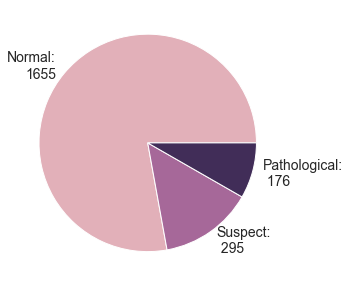

In [11]:
#   pie plot
plt.figure(figsize=(5,5), facecolor='white')
fh_values = df_fetal_health.fetal_health.value_counts()  # value_counts to create the pie plot
plt.pie(fh_values,labels=['Normal:\n'+str(fh_values.iloc[0]),'Suspect:\n '+str(fh_values.iloc[1]),'Pathological:\n '+str(fh_values.iloc[2])], colors= health_palette, textprops={'fontsize': 14})
plt.show()

Dataset is (fortunately) unbalanced. Class 1 (Normal) is an order of magnitude more populated the the other two.

Correlation Heatmap:

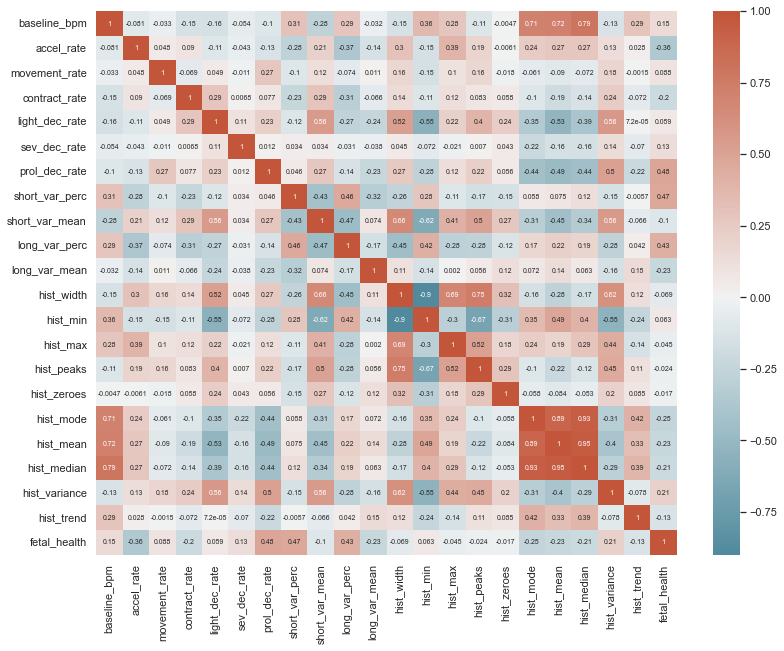

In [12]:
plt.figure(figsize=(13,10))
heat_palette = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(df_fetal_health.corr(),annot=True, center= 0, annot_kws={'size':'xx-small'}, cmap= heat_palette)
plt.show()

I want to select the features that are more correlated with the target 'fetal_health' column.

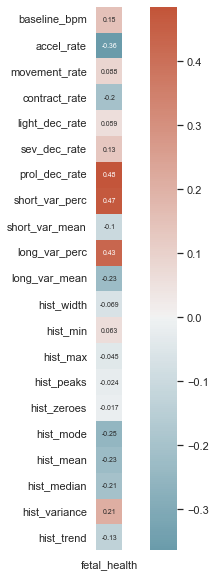

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(df_fetal_health.corr().fetal_health[0:-1]),annot=True, center= 0, annot_kws={'size':'xx-small'}, cmap= heat_palette, square= True)
plt.show()

There are no strong correlations, I select a relatively low minimum threshold (0.3).

In [14]:
best_corr = df_fetal_health.corr().fetal_health[(df_fetal_health.corr().fetal_health.abs() >0.3) & (df_fetal_health.corr().fetal_health.abs() <1)]
pd.DataFrame(best_corr).style.background_gradient(cmap=heat_palette)

,fetal_health
accel_rate,-0.364066
prol_dec_rate,0.484859
short_var_perc,0.471191
long_var_perc,0.426146


I have four features with a correlation higher than the threshold: 'accel_rate', number of heartbeat accelerations per second; 'prol_dec_rate', number of prolongued heartbeat decelerations per second; 'short_var_perc', percentage of time with abnormal short term variability; 'long_var_perc', percentage of time with abnormal long term variability.

I want to observe more closely these features.

In [15]:
feat_list = list(best_corr.index)       # names list with significant correlations
feat_list.append('fetal_health')        # add the target name
df_fh_rid = df_fetal_health[feat_list]  # reduced DataFrame
df_fh_rid.head()

,accel_rate,prol_dec_rate,short_var_perc,long_var_perc,fetal_health
0,0.000,0.0,73.0,43.0,2.0
1,0.006,0.0,17.0,0.0,1.0
2,0.003,0.0,16.0,0.0,1.0
3,0.003,0.0,16.0,0.0,1.0
4,0.007,0.0,16.0,0.0,1.0


In [16]:
# I want to build a new dataframe with string type values in the target column 'fetal_health'.
# This way I can use the 'order' parameter when drawing plots.

# Need a dictionary to convert float to string:
fh_values = np.sort(np.unique(df_fh_rid.fetal_health.values))
fh_list = ('Normal','Suspect','Pathological')
fh_dict = {fh_values[i]: fh_list[i] for i in range(len(fh_list))}

# Create new dataframe
df_fh_string = df_fh_rid.copy()
df_fh_string.fetal_health = df_fh_string.fetal_health.map(fh_dict)
df_fh_string.head()


,accel_rate,prol_dec_rate,short_var_perc,long_var_perc,fetal_health
0,0.000,0.0,73.0,43.0,Suspect
1,0.006,0.0,17.0,0.0,Normal
2,0.003,0.0,16.0,0.0,Normal
3,0.003,0.0,16.0,0.0,Normal
4,0.007,0.0,16.0,0.0,Normal


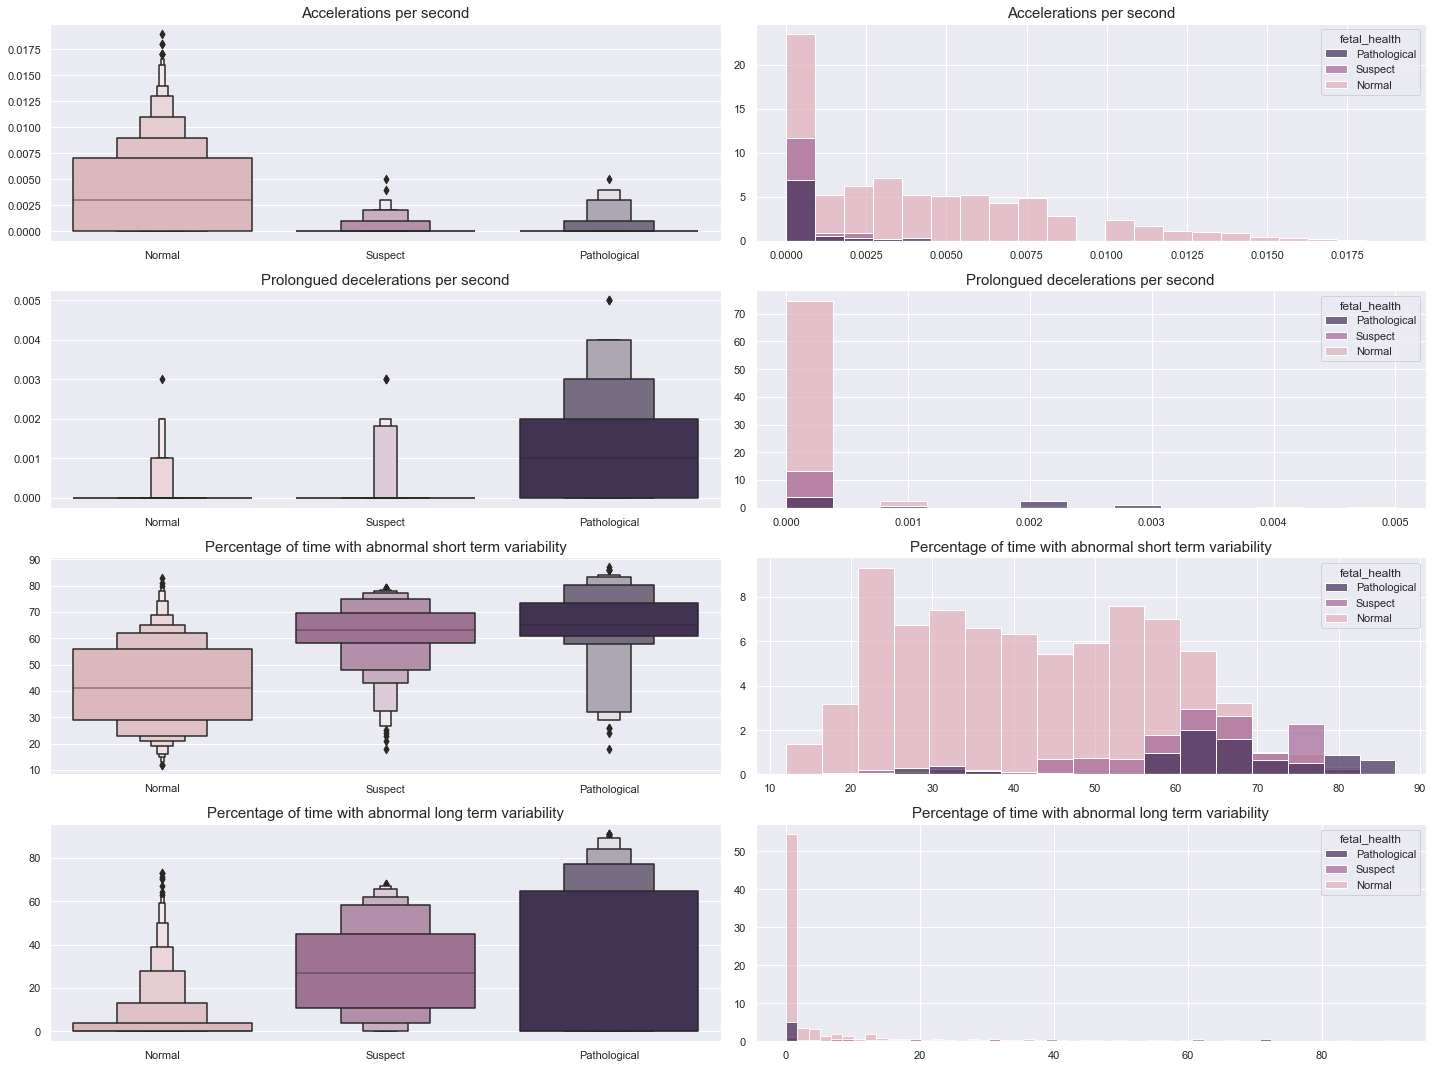

In [17]:
titles = ['Accelerations per second','Prolongued decelerations per second','Percentage of time with abnormal short term variability',
          'Percentage of time with abnormal long term variability']     # Plott titles list

fig, ax = plt.subplots(4,2, figsize=(20,15))
for i,feat in enumerate(feat_list[:-1]):
    #   box plot
    box_plot = sns.boxenplot(ax=ax[i,0], data=df_fh_string, x=df_fh_string.fetal_health, y= df_fh_string[feat], orient= 'v', order=fh_list, palette= health_palette, saturation= 0.7)
    box_plot.set_title(titles[i], fontsize=15)
    box_plot.set(xlabel= None, ylabel= None)
    #   histogram
    hist_plot = sns.histplot(ax=ax[i,1], data=df_fh_string, x= df_fh_string[feat].values,stat='percent', hue= df_fh_string.fetal_health, hue_order=fh_list[::-1], palette= health_palette[::-1], alpha= 0.7)
    hist_plot.set_title(titles[i], fontsize=15)
    hist_plot.set(ylabel= None)
plt.tight_layout()
plt.show()

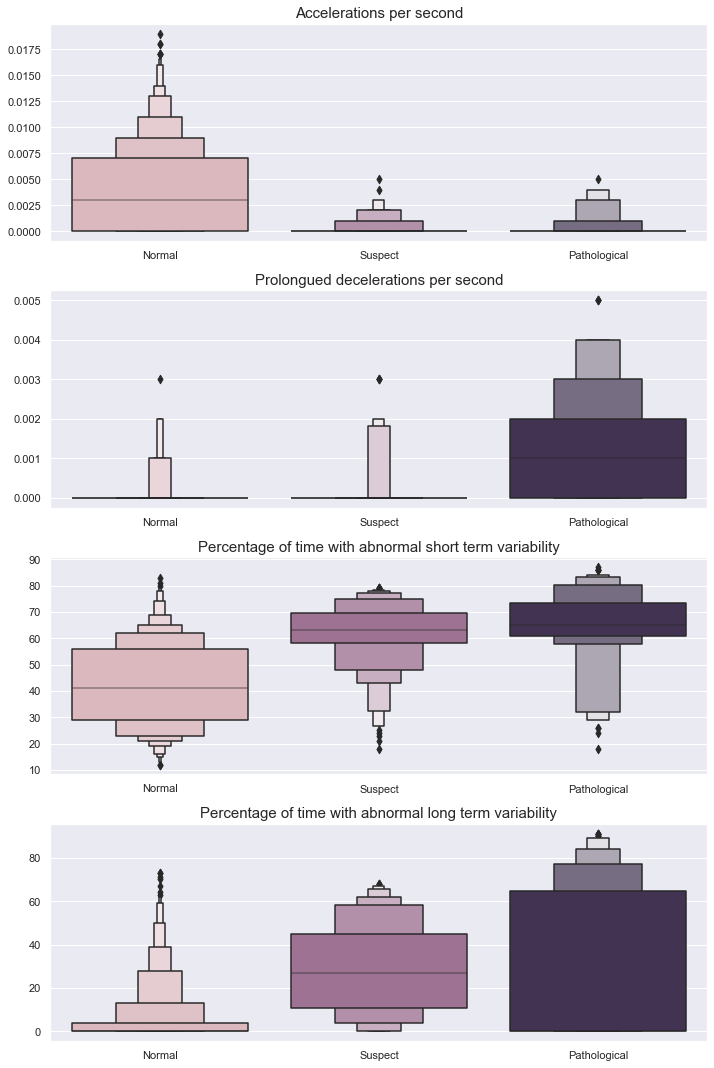

In [18]:
fig, ax = plt.subplots(4,1, figsize=(10,15))
for i,feat in enumerate(feat_list[:-1]):
    #   box plot
    box_plot = sns.boxenplot(ax=ax[i], data=df_fh_string, x=df_fh_string.fetal_health, y= df_fh_string[feat], orient= 'v', order=fh_list, palette= health_palette, saturation= 0.7)
    box_plot.set_title(titles[i], fontsize=15)
    box_plot.set(xlabel= None, ylabel= None)
plt.tight_layout()
plt.show()

Boxplots show outliers presence; however, I want to keep all the data available for several reasons. The most important reason is that the goal of this alaysis is to identify potential pathological cases for preventive purposes. Since it is reasonable to assume, as a precaution, that values in the distribution tails could be related to fetal health anomalies, I want to keep the information provided by these data.

# Preprocessing

In [19]:
# I separate the feature matrix from the target vector.

X = df_fetal_health.drop(['fetal_health'],axis=1)
y = df_fetal_health.fetal_health

Scaling (Standard Scaler)

In [19]:
scaler = StandardScaler()
X_scal = scaler.fit_transform(X)
X_scal = pd.DataFrame(X_scal, columns= X.columns.tolist())

Encoding

Label Encoder to rename target classes (1,2,3) to (0,1,2). I need this operation in order to use XGBoost model.

In [20]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

Train Test Split (20% train - 80% test)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1700, 21), (426, 21), (1700,), (426,))

# Model Selection

Provo con quattro modelli per valutarne i risultati:
I want to try four different models, testing their outcome:
- KNN
- Decision Tree
- Random Forest
- XGBoost

In [22]:
# Create classifier istances

classifier = []
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()
rnd_forest = RandomForestClassifier()
xgboost = XGBClassifier()

In [23]:
# Dictionary with most important metrics

scorer = {
    'accuracy':make_scorer(accuracy_score),
    'precision':make_scorer(precision_score, average= 'macro'), # 'macro' value in 'average' parameter, to compute the metric with unweighted avarage
    'recall':make_scorer(recall_score, average= 'macro'),
    'F1':make_scorer(f1_score, average= 'macro')
}

In [24]:
knn_score = cross_validate(knn, X_train,y_train, scoring=scorer)
for i in list(knn_score.keys())[2:]:
    print(i, ': ',knn_score[i].mean())

test_accuracy :  0.8847058823529412
test_precision :  0.8360705085876707
test_recall :  0.7526941703273048
test_F1 :  0.7876371553787048


In [25]:
tree_score = cross_validate(tree, X_train,y_train, scoring=scorer)
for i in list(tree_score.keys())[2:]:
    print(i, ': ',tree_score[i].mean())

test_accuracy :  0.9223529411764707
test_precision :  0.8804780419640303
test_recall :  0.8723913917639953
test_F1 :  0.8746695858382021


In [26]:
forest_score = cross_validate(rnd_forest, X_train,y_train, scoring=scorer)
for i in list(forest_score.keys())[2:]:
    print(i, ': ',forest_score[i].mean())

test_accuracy :  0.9405882352941177
test_precision :  0.9137949047931025
test_recall :  0.8675063589623246
test_F1 :  0.8882290674025348


In [27]:
xgboost_score = cross_validate(xgboost, X_train,y_train, scoring=scorer, return_estimator= False)
for i in list(xgboost_score.keys())[2:]:
    print(i, ': ',xgboost_score[i].mean())

test_accuracy :  0.9523529411764706
test_precision :  0.9230290868703444
test_recall :  0.9084930261555423
test_F1 :  0.9150961830821005


I choose recall as the reference metric because it allows me to minimize false negatives. Since the dataset is imbalanced and the two most important classes are less populated, I calculate recall (and other metrics) with an unweighted average.

The model that performs best still appears to be XGBoost, even when considering the other metrics.

# Tuning

Parameters for Grid Search (description from the XGBoost documentation):
- min_child_weight: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
- max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
- subsample: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
- eta: Step size shrinkage used in update to prevents overfitting.

In [28]:
params = {'min_child_weight': [1, 5, 10],
          'max_depth': [4, 5, 6, 7],
          'subsample': [0.6, 0.8, 1.0],
          'eta': [0.1, 0.2, 0.3, 0.4]
          }

In [29]:
grid_s = GridSearchCV(estimator= XGBClassifier(), param_grid= params, scoring= make_scorer(recall_score, average= 'macro'), cv= 5, verbose= 10)
grid_s.fit(X_train, y_train)
best_xgb = grid_s.best_estimator_           # best estimator
best_score = grid_s.best_score_             # best score (recall)
best_params = grid_s.best_params_           # best parameters

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5; 1/144] START eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6...
[CV 1/5; 1/144] END eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.934 total time=   0.3s
[CV 2/5; 1/144] START eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6...
[CV 2/5; 1/144] END eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.924 total time=   0.2s
[CV 3/5; 1/144] START eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6...
[CV 3/5; 1/144] END eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.893 total time=   0.2s
[CV 4/5; 1/144] START eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6...
[CV 4/5; 1/144] END eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.868 total time=   0.2s
[CV 5/5; 1/144] START eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6...
[CV 5/5; 1/144] END eta=0.1, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.924 total 

In [30]:
print('Best score: recall = ', best_score)
print('Best parameters: ', best_params)

Best score: recall =  0.9130471352339388
Best parameters:  {'eta': 0.4, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}


# Evaluation

In [31]:
xgb = XGBClassifier(eta= 0.4, max_depth= 5, min_child_weight= 1, subsample= 1.0)    # new classifier with parameters from the grid search
xgb.fit(X_train, y_train)                                                           # fit over the whole train set
y_pred = xgb.predict(X_test)                                                        # prediction
print(classification_report(y_test, y_pred, digits= 4))                             

              precision    recall  f1-score   support

           0     0.9586    0.9759    0.9672       332
           1     0.8654    0.7627    0.8108        59
           2     0.8889    0.9143    0.9014        35

    accuracy                         0.9413       426
   macro avg     0.9043    0.8843    0.8931       426
weighted avg     0.9399    0.9413    0.9401       426



Recall is very good for the 'Normal' and 'Pathological' classes, but it is significantly lower for the intermediate 'Suspected' class, which lowers the overall average.

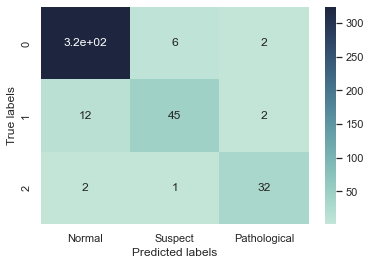

In [32]:
# Confusion Matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax, cmap= sns.cubehelix_palette(rot=-.3, n_colors=21, as_cmap= True))

ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels"); 
ax.xaxis.set_ticklabels(["Normal", "Suspect", "Pathological"]);

Feature importance

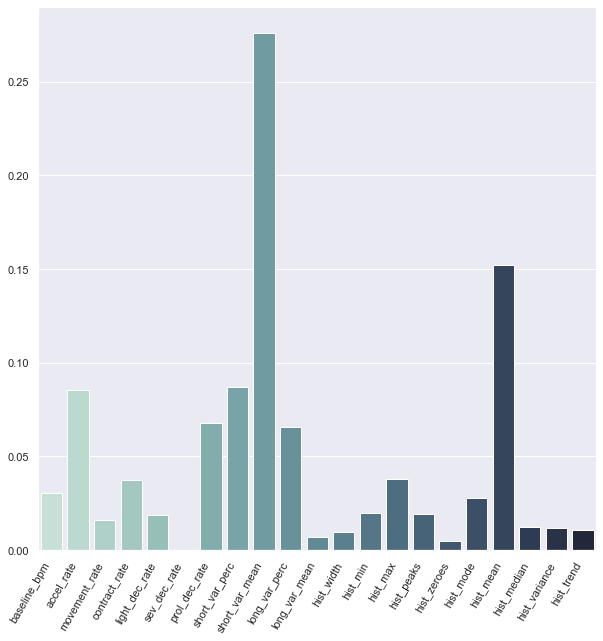

In [33]:
plt.figure(figsize=(10,10))
ax = sns.barplot(x= list(X.columns), y= xgb.feature_importances_, palette = sns.cubehelix_palette(rot=-.3, n_colors=21))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha= 'right')
plt.show()

The four features initially selected based on correlation are, as expected, among the most important in the decision made with XGBoost. However, the two that are clearly the most decisive are 'short_var_mean', which represents the mean value of short term variability, and 'hist_mean', which represents the average value of the heart rate distribution histogram.